In [19]:
import pandas as pd
#read tsv file
nuclei = pd.read_csv('/mnt/md0/lei/projects/CellSegmentsation/CellSegmentation/results/task2_result.txt', sep=' ', header=None)
#for nuclei[3] == 54, get all x and y (nuclei[0] and nuclei[1])
import numpy as np
coordinate = nuclei[(nuclei[3] == 54)][[0,1]].values
df = pd.read_csv('/mnt/md0/lei/projects/CellSegmentsation/CellSegmentation/data/Mouse_brain_Adult_GEM_bin1_sub.tsv', sep='\t')
df2 = df[(df['x'] <= np.max(coordinate[:,0])+800) & (df['x'] >=  np.min(coordinate[:,0])+800) & (df['y'] >= np.min(coordinate[:,1])) & (df['y'] <= np.max(coordinate[:,1]))]
df2 = df2.groupby(['x', 'y','geneID']).agg({'MIDCounts': 'sum'}).reset_index()

In [21]:
results_list = []

for nuclei_id in nuclei[3].unique():
    
    # if nuclei_id == 0:  # 跳过 NucleiID 为 0 的行
    #     continue
    # 获取当前细胞核的所有点坐标
    coordinate = nuclei[nuclei[3] == nuclei_id][[0, 1]].values
    
    # 计算像素数量（坐标点数量）
    pixel_count = len(coordinate)
    
    # 基于坐标筛选 df 中的相关数据
    # 注意：这里假设你的坐标筛选逻辑是正确的，即考虑到了坐标的最大最小值和偏移量
    df2 = df[(df['x'] <= np.max(coordinate[:, 0])+800) & 
             (df['x'] >= np.min(coordinate[:, 0])+800) & 
             (df['y'] >= np.min(coordinate[:, 1])) & 
             (df['y'] <= np.max(coordinate[:, 1]))]
    
    # 计算并添加当前细胞核的总基因表达记录数
    total_gene_expression_records = len(df2)
    results_list.append((nuclei_id, total_gene_expression_records,pixel_count))
    results_df = pd.DataFrame(results_list, columns=['NucleiID', 'TotalGeneExpressionRecords','PixelCount'])

# 显示结果 DataFrame
results_df


,NucleiID,TotalGeneExpressionRecords,PixelCount
0,0.0,169454,134922
1,52.0,450,184
2,5.0,2922,687
3,8.0,678,275
4,22.0,677,281
...,...,...,...
137,4.0,214,236
138,95.0,64,87
139,109.0,204,193
140,134.0,66,101


/home/lei/miniconda3/envs/CS/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lei/miniconda3/envs/CS/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


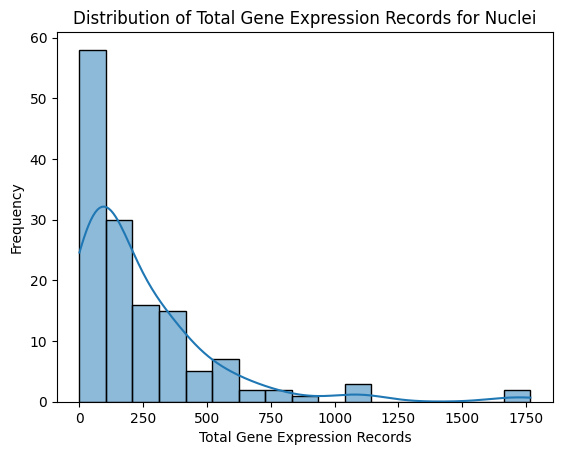

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
filtered_df = results_df[results_df['NucleiID'] != 0]

# 画出 TotalGeneExpressionRecords 的分布图
sns.histplot(filtered_df['TotalGeneExpressionRecords'], kde=True)
plt.title('Distribution of Total Gene Expression Records for Nuclei')
plt.xlabel('Total Gene Expression Records')
plt.ylabel('Frequency')
plt.show()

/home/lei/miniconda3/envs/CS/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lei/miniconda3/envs/CS/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


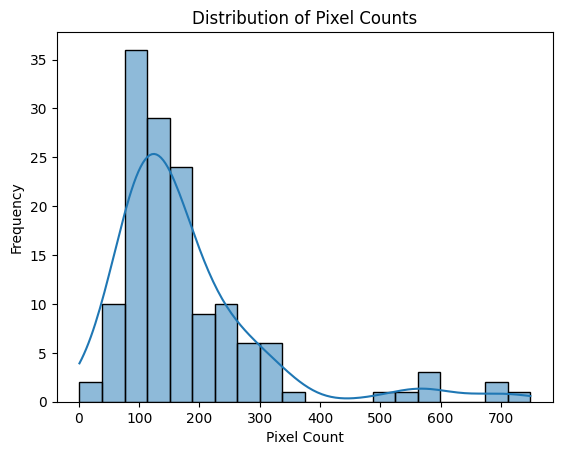

In [16]:
# 画出 PixelCount 的分布图
sns.histplot(filtered_df['PixelCount'], kde=True)
plt.title('Distribution of Pixel Counts')
plt.xlabel('Pixel Count')
plt.ylabel('Frequency')
plt.show()

In [18]:

print('Average Total Gene Expression Records:', filtered_df['TotalGeneExpressionRecords'].mean())
print('Average Pixel Count:', filtered_df['PixelCount'].mean())

Average Total Gene Expression Records: 405.9929078014184
Average Pixel Count: 177.8581560283688


In [5]:
import anndata as ad
import math
from scipy.sparse import lil_matrix
import scanpy as sc
import numpy as np
import pandas as pd

adatasub=ad.read_h5ad("../SCS/data/spots0:0:0:0.h5ad")
bin_file = "data/Mouse_brain_Adult_GEM_bin1_sub.tsv"
xall = []
yall = []
with open(bin_file) as fr:
    header = fr.readline()
    for line in fr:
        gene, x, y, count = line.split()
        xall.append(int(x))
        yall.append(int(y))
xmin = np.min(xall)
ymin = np.min(yall)
# print(np.min(xall), np.min(yall), np.max(xall), np.max(yall))

# find all the genes in the range
geneid = {}
genecnt = 0
id2gene = {}
with open(bin_file) as fr:
    header = fr.readline()
    for line in fr:
        gene, x, y, count = line.split()
        if gene not in geneid:
            geneid[gene] = genecnt
            id2gene[genecnt] = gene
            genecnt += 1

idx2exp = {}
downrs = 3
patchsizex=1200
patchsizey=1200
startx=0
starty=0
with open(bin_file) as fr:
    header = fr.readline()
    for line in fr:
        gene, x, y, count = line.split()
        x = int(x) - xmin
        y = int(y) - ymin
        if gene not in geneid:
            continue
        if int(x) < int(startx) or int(x) >= int(startx) + int(patchsizex) or int(y) < int(starty) or int(y) >= int(
                starty) + int(patchsizey):
            continue
        idx = int(math.floor((int(x) - int(startx)) / downrs) * math.ceil(patchsizey / downrs) + math.floor(
            (int(y) - int(starty)) / downrs))
        if idx not in idx2exp:
            idx2exp[idx] = {}
            idx2exp[idx][geneid[gene]] = int(count)
        elif geneid[gene] not in idx2exp[idx]:
            idx2exp[idx][geneid[gene]] = int(count)
        else:
            idx2exp[idx][geneid[gene]] += int(count)

all_exp_merged_bins = lil_matrix((int(math.ceil(patchsizex / downrs) * math.ceil(patchsizey / downrs)), genecnt),
                                    dtype=np.int8)
for idx in idx2exp:
    for gid in idx2exp[idx]:
        all_exp_merged_bins[idx, gid] = idx2exp[idx][gid]
        # print(idx, gid, idx2exp[idx][gid])
all_exp_merged_bins = all_exp_merged_bins.tocsr()
# print(all_exp_merged_bins.shape)

all_exp_merged_bins_ad = ad.AnnData(
    all_exp_merged_bins,
    obs=pd.DataFrame(index=[i for i in range(all_exp_merged_bins.shape[0])]),
    var=pd.DataFrame(index=[i for i in range(all_exp_merged_bins.shape[1])]),
)
sc.pp.highly_variable_genes(all_exp_merged_bins_ad, n_top_genes=2000, flavor='seurat_v3', span=1.0)
selected_index = all_exp_merged_bins_ad.var[all_exp_merged_bins_ad.var.highly_variable].index
selected_index = list(selected_index)
selected_index = [int(i) for i in selected_index]
# selected_index = geneidx[selected_index]
# print(selected_index, len(selected_index))

# check total gene counts
all_exp_merged_bins = all_exp_merged_bins.toarray()[:, selected_index]

/home/lei/miniconda3/envs/CS/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/lei/miniconda3/envs/CS/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [2]:
counts = np.count_nonzero(all_exp_merged_bins, axis=1)
np.mean(counts)

0.81368125

In [2]:
results=[]

for nuclei_id in nuclei[3].unique():
    
    if nuclei_id == 0:  # 跳过 NucleiID 为 0 的行
        continue
    # 获取当前细胞核的所有点坐标
    coordinate = nuclei[nuclei[3] == nuclei_id][[0, 1]].values
    # print(coordinate.shape)
    x=coordinate[:,0]+800
    y=coordinate[:,1]
    idx = (np.floor(x / downrs) * np.ceil(patchsizey / downrs) + np.floor(y / downrs)).astype(int)
    # idx=int(math.floor(x / downrs) * math.ceil(patchsizey / downrs) + math.floor(y / downrs))
    nuclei_exp=all_exp_merged_bins[idx,:]
    total_non_zero = np.count_nonzero(nuclei_exp)
    # 将结果添加到列表中
    results.append([nuclei_id, total_non_zero])


results_df = pd.DataFrame(results, columns=['NucleiID', 'TotalGeneExpressionRecords'])
results_df

NameError: name 'nuclei' is not defined

/home/lei/miniconda3/envs/CS/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lei/miniconda3/envs/CS/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


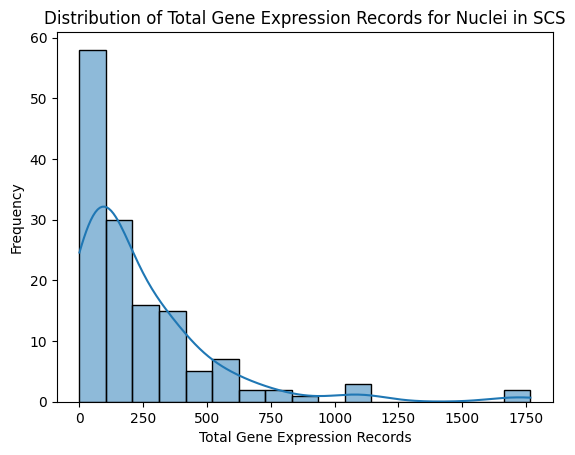

In [25]:
sns.histplot(results_df['TotalGeneExpressionRecords'], kde=True)
plt.title('Distribution of Total Gene Expression Records for Nuclei in SCS')
plt.xlabel('Total Gene Expression Records')
plt.ylabel('Frequency')
plt.show()

In [26]:
print('Average Total Gene Expression Records:', results_df['TotalGeneExpressionRecords'].mean())
# print('Average Pixel Count:', filtered_df['PixelCount'].mean())

Average Total Gene Expression Records: 240.27659574468086


In [3]:
re=[]
for i in range(adatasub.layers['watershed_labels'].shape[0]):
    for j in range(adatasub.layers['watershed_labels'].shape[1]):
        if (not i % downrs == 0) or (not j % downrs == 0):
            continue
        idx = int(math.floor(i / downrs) * math.ceil(patchsizey / downrs) + math.floor(j / downrs))
        if adatasub.layers['watershed_labels'][i, j] > 0:
            re.append(all_exp_merged_bins[idx, :])

re=np.array(re)

NameError: name 'adatasub' is not defined